# 2017 VA House of Delegates Election

## Preparing the data

### precinct.data

I'm going to do the same cleaning that I do here (https://htmlpreview.github.io/?https://github.com/madiemoxie/ap-research-redistricting/blob/master/notes/VA_HOD_2017_tocsv.html), but in R so that I don't have to deal with the mess of trying to export python data frames to .rda files. 

_I'm doing this for the 2011 data set that I created to see if my cleaning was successful._

In [1]:
print(getwd())

[1] "C:/Users/madie/ap-research-redistricting/mcmc/va-official-2011/2011_redist"


In [2]:
library(sf)
library(ggplot2)
library(dplyr)
library(tibble)
library(magrittr)

precinct.data <- st_read("../2011_shp/VA_precincts_2011.shp")
df <- data.frame(precinct.data)
hid <- precinct.data %>%
    select(HDIST_11)

# copy over useful cols and rename them
precinct.data <- precinct.data %>%
    select(pop = TOTPOP,
           vap = VAP,
           obama = G11DHOD,
           mccain = G11RHOD,
           TotPop = TOTPOP,
           BlackPop = NH_BLACK,
           HispPop = HISP,
           VAP_1 = VAP,
           BlackVAP = BVAP,
           HispVAP = HVAP,
           geometry = geometry)
# add col geoid10 based off of index
precinct.data <- cbind(geoid10 = rownames(precinct.data), precinct.data)
# change all cols to numeric type
precinct.data %<>% 
      mutate_each(funs(if(is.character(.)) as.numeric(.) else .))
head(precinct.data)

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




Reading layer `VA_precincts_2011' from data source `C:\Users\madie\ap-research-redistricting\mcmc\va-official-2011\2011_shp\VA_precincts_2011.shp' using driver `ESRI Shapefile'
Simple feature collection with 2906 features and 39 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -373531.2 ymin: 60026.37 xmax: 380257.5 ymax: 385298.6
projected CRS:  Lambert_Conformal_Conic


Warning message:
"`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."
Warning message:
"`mutate_each_()` is deprecated as of dplyr 0.7.0.
Please use `across()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


,geoid10,pop,vap,obama,mccain,TotPop,BlackPop,HispPop,VAP_1,BlackVAP,HispVAP,geometry
,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [m]>
1,1,2519,2015,194,544,2519,602,198,2015,434,132,MULTIPOLYGON (((261705.9 22...
2,2,2521,2094,228,653,2521,495,62,2094,377,39,MULTIPOLYGON (((258909.1 21...
3,3,1544,1225,189,196,1544,869,30,1225,663,15,MULTIPOLYGON (((271256.2 20...
4,4,836,652,89,68,836,559,10,652,430,8,MULTIPOLYGON (((271763.6 20...
5,5,2454,2172,253,711,2454,276,26,2172,215,19,MULTIPOLYGON (((281272.6 19...
6,6,2456,2151,216,753,2456,305,56,2151,246,40,MULTIPOLYGON (((284502.4 20...


## Redistricting!

### Adjacency - based redistricting

The second part that MCMC requires is an `adjlist`, or a list for every precinct of the precinct that it is adjacent to. This can be accomplished by using the `poly2nb` function from the `spdep` package.

In [3]:
library(sp)
library(spData)
library(spdep)

adjlist <- poly2nb(precinct.data, queen = FALSE) # queen = FALSE means that being kitty corner doesn't qualify.
adjlist

Neighbour list object:
Number of regions: 2906 
Number of nonzero links: 22954 
Percentage nonzero weights: 0.2718111 
Average number of links: 7.89883 

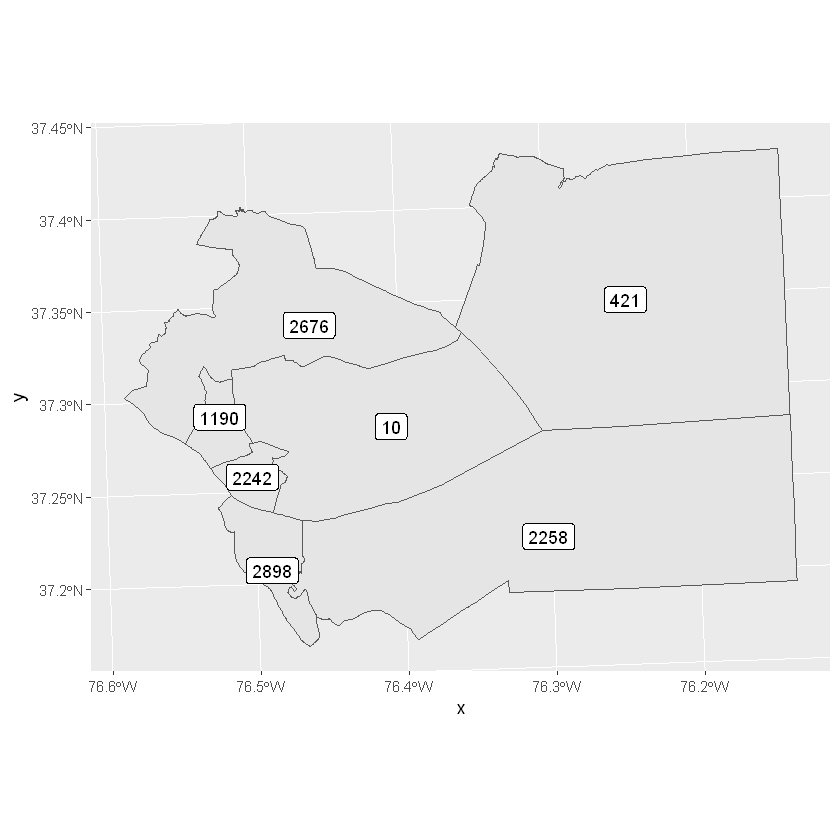

In [10]:
precinct.data$id <- 1:2906
# visualize and label a small smattering of precincts
precinct.data[c(10, 421, 1190, 2242, 2258, 2656, 2661, 2666, 2671, 2676, 2896, 2898),] %>% ggplot() + 
  geom_sf() +
  geom_sf_label(aes(label = id))

In [9]:
# list all precincts that this one is adjacent to. 
adjlist[[10]]

[1]  421 1190 2242 2258 2656 2661 2666 2671 2676 2896 2898

In [11]:
# The C++ backend is more efficient if it's zero-indexed. 
for(i in 1:2906){
  adjlist[[i]] <- adjlist[[i]]-1
}

### Using MCMC

This is just a single chain. Note that this takes about 30 min to run. 

In [13]:
library(redist)
va.mcmc <- redist.mcmc(adjobj = adjlist,
                    popvec = precinct.data$pop,
                    ndists = 100,
                    nsims = 10000,
                    savename = "redist.mcmc.va", 
                    maxiterrsg = 1000000000)


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.957958

20 percent done.
Metropolis acceptance ratio: 0.955478

30 percent done.
Metropolis acceptance ratio: 0.961987

40 percent done.
Metropolis acceptance ratio: 0.962991

50 percent done.
Metropolis acceptance ratio: 0.962192

60 percent done.
Metropolis acceptance ratio: 0.963994

70 percent done.
Metropolis acceptance ratio: 0.964281

80 percent done.
Metropolis acceptance ratio: 0.96387

90 percent done.
Metropolis acceptance ratio: 0.962329

100 percent done.
Metropolis acceptance ratio: 0.961496



The previous block seems to throw an error saying that `maxiterrsg` is too small. A look in `redist_findparams.R` of the `redist` source code says the following: 
> @param maxiterrsg Maximum number of iterations for random seed-and-grow algorithm to generate starting values. Default is 5000.

Setting`maxiterrsg` to 1,000,000,000 got it to run, but it takes about 30 min.

From `redist` docs: 
>Once we’ve run the algorithm, the output is of class redist. As savename was provided, there is an Rdata file created in the working directory with a copy of the output.

In [14]:
names(va.mcmc)

[1] "partitions"             "distance_parity"        "distance_original"     
 [4] "mhdecisions"            "mhprob"                 "pparam"                
 [7] "beta_sequence"          "energy_psi"             "constraint_pop"        
[10] "constraint_compact"     "constraint_segregation" "constraint_similar"    
[13] "constraint_countysplit" "boundary_partitions"    "boundaryratio"

> For simple runs of the algorithm, the most important pieces of the output are `partitions` and `distance_parity`. The partitions object is a matrix with ndist rows and nsims columns. Each column is one redistricting plan, where the numbers go from 0 to n-1, with each number represents the district assignment.

In [15]:
va.mcmc$partitions[,1]

[1]  0  0  0 30  3  0 61 49  0 30 69 43  5 57 87 20 34 41 67  8 63 44  7 53
  [25]  9 11 12 57 87 34 83 59 45 16 88 72 79 81 98 27 74 27 87 20  9 45  1 44
  [49] 51 87 54 96 33 37 74 27 43  0 69 49 39 93 93  0 69 48 25 93 10 83 23 31
  [73] 48 57 79 59 62 94 38 16 16 99 49 65 49 31 79 48 20 83 12 82 90 16 29 88
  [97] 53 40 37 53 29 37 95 62 62 43 83 29 68 18 37 12 34 56 13  1 78 78 25 55
 [121] 42 86 77 96 54 18 77 84 63 86 13 69 54 36 77 69 63 11 45 31 52 72 79 34
 [145]  5 92 73 41  6 50  7 88 10 88 23  0 55 37 22 94 90 90 55 56 91 90 41 54
 [169] 51 51 25 56 91 15 55 56 28 94 77 73 56 14 72 77 32 16 88 68 93 10 16 55
 [193] 61 72 55 10 72 39 41 72 10 96 26  4 10 18 78  0 14 14 87 75 94 12 44 18
 [217]  3 42 93 48 26 14 51 73 14 75  4 73 15 40 93 12 10 44 57 10 83 39 88 21
 [241] 10 53 66 19 29 79 53 90 25 43 85 57 19 92 25 87 11 59 11  7 36 83 18 19
 [265] 33 35 84 67 75 81 93 83 59 13 59 34 59 46 75 14 95 49 66 94 78 81 64 44
 [289] 44 57 16 87 92 53 95 37 51 19 58 16 98 75 14 12 16 17  5 99 12 73 85 58
 [313] 85 65 78  9 19 49 85 22 71 96 58 69 63  8 39 41 56 58 59 40 94 61 41 61
 [337] 35 35 90 22 57 90 83 86 61 22  5 85 66 97 73 99 79 36 23  6 47  7 71 71
 [361]  7 37 24 89 53 92 28 93 18 70 44 89 21 55 96 39 41 28 21 55 36 37 90 70
 [385] 27 37 90 12 38 30 51 70 27  0 91 12 49 96 45 95 89 98 60 96 40 35 44 65
 [409] 15 17 12 83 12 80 70 33 12 22 58 97  3 62 22 60 25 20 30 37 88 69  4 67
 [433] 18 43 81  0 54 31 13 85 20 76 97 46 46 46 46 64 24 90 49 20 49 88 27  5
 [457] 47 53 88 44 11 98 40 70  7 43 93 39 97 78 16 89 12 72 16 16 72 70 75 28
 [481]  2 89 37 62 95 66 39 75 82 82 21 62 86 27 19 18 49 31 18 27 74  9 43 89
 [505] 34 75  7 16 16 37 53 69 94 67 90 97 51 60 14 55 72 16 72 47 21 32 73 16
 [529]  5 97 44 70 67 45 67 70 99 34 34 45 66 30  0  3  0 81 20 61 59 44 44 37
 [553] 36 45 33 37  4  4 80 39 41 61 59 44 70 40 29 73 80 88 37  3 80 39 41 61
 [577] 87 34 70  0 18 82 33 30  4  3 88 55 61 22 87 34 70 18 40 45 66  4 37  4
 [601]  0 55 41 10 59 44 70 40 29 45 79  4 30 30 80 39 41 61 87 34 93 40 18 45
 [625] 33  0 37  4  0 39 22 22 59 34 44 69 36 73 33  0 37  3 88 39 20 41 59 34
 [649] 12 96 18 73 66 37  0 91 80 21 41 61 87 67 70 69 40 98 41 10 51 85 45 45
 [673] 14 13 55 32 84 85 42 19 23 68 63 55 68 58 86 24 82 21 24 62 44 24 74 48
 [697] 70 64 49 24 38 49  2 36 39  4 86 18 21 20 80  8 56 99 43 45 44 63 12 83
 [721] 16  3 44 47 32 43 13 43 48 40 97  7 95 15 41 61 55 51 35  4 92 32 14 15
 [745] 10 96 82  9 76 99 14 10 10  9 14 74 11 88 24 72 88 31 20 44 45 80 77 10
 [769] 16 41 44 12 94 98 72 45 93 72 45 35 96 54 46 16 86 78 77 93 50 23 53 14
 [793] 89 42 50  7 43 64 43 47 70  7 66 74 70 20  5 16 94 94 29 62 98 72 99  6
 [817] 50 72 72 98 91  8  1 41 77  3 76  4 22 44 68 71 81 24 19  1 75 59 45 42
 [841] 32 32 32 77 77 38 82 59 20 77 37 98 47 88 71 95 96 22 67  4 72 23 73 66
 [865] 88 56 91 29 22  6 68 98 11 87 83 98 94 95 32 43 53 53 68 14 72 39 34  2
 [889]  2 89  1 69 75 78 39 30 75 17  1 37 14 52 48 37 67 52 48 78 14 36 72 43
 [913] 26 75 29 72 98 89 75 29 72 43 26 99 40 72 43 26 75 36 72 43 89 25 77 34
 [937] 16 80 98 44 11 96 55 55 73 33 93 12 36 88 76 93 49 44 49 76  5 74 47 75
 [961] 76 75 14 14 14 64 52 44 89 32 77 42 68 42 68 77 42 29 36 28 76 13 83 43
 [985] 72  9  2  2 82 11 33  6 97 93 50 86 41 15 72 74 45 64 17 57 56 89 29 42
[1009] 68 68 68 42 77 31 36 22 16 76 75 75 75 34 47  2 21 52 35 71 37 18 24 35
[1033] 52 35 54 60 28 98 43 16  2 47  2  7  7 16  6 63  6 72 83 66 36 66 40 28
[1057] 85 68 78 78 23 86 40 25 50 69  1  5 37 23 86 25 54 85 99  9 82 47 82 98
[1081]  5 70 49 84 31 74 69 16 92 44 73 39 28 73 18 28 36 14 12  7 75 66 83 88
[1105] 15 33  3 65 16 74 16 54 46  6 43 55 47 57 25 41 97  8 30 43 73 81 25 89
[1129] 23  0  2 35 39 69 16 84 47 73 42 99 68 63 24 94 11 91 69 94  4 69 87  4
[1153] 84 71 12 79 14 31 64 46 31 72 52 49 63 49 93 86 53 83 80 56 33 52 20 23
[1177] 40 59 79 68  3 14 11 10 22 79 90 27 95  4 17 48 47 16 29 99 14 56 44 93
[1201] 22 73 72 53 65 11 19 92 96 35 35  9 97 55 41  

> The `distance_parity` output provides the population parity of the districts as an array with `nsims` entries.

In [16]:
va.mcmc$distance_parity[1]

[1] 0.03404846

Saving 13.3 x 13.3 in image



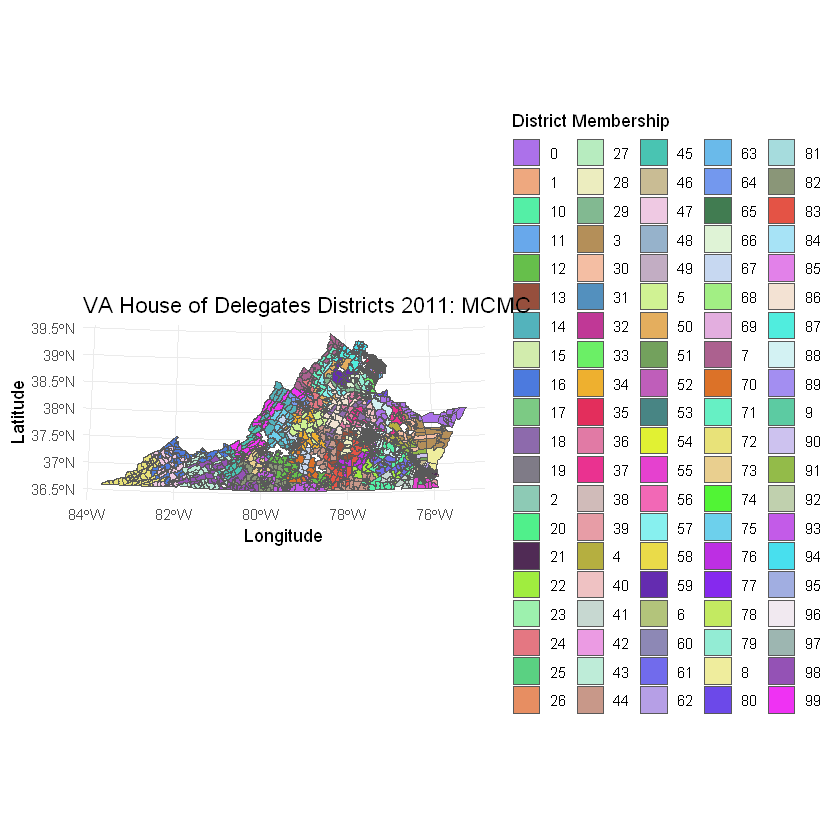

In [19]:
library(randomcoloR)
# generate 100 random colors that are distinct so that the different districts are distinguishable. 
colors <- distinctColorPalette(k=100)

# Let's plot this!
cds <- va.mcmc$partitions[,1]
plot <- redist.map(shp=precinctD.data, 
        district_membership=cds, 
        centroids=FALSE, 
        edges=FALSE,
        title="VA House of Delegates Districts 2011: MCMC") +
        theme(legend.position="right") +
        scale_fill_manual(values = colors)
        # geom_sf_label(aes(label = cds))
ggsave("2011.png", scale=2)

plot

### Using Multiple Chains

> When running larger redistricting analyses, one important step is to run multiple chains of the MCMC algorithm. This will also allow us to diagnose convergence better, using the Gelman-Rubin plot, as seen in the section on Diagnostic Plots.
On Windows and in smaller capacities, it is useful to run the algorithm within an lapply loop. First, we set up the seed for replicability and decide on the number of chains and simulations.

In [20]:
RNGkind(kind = "L'Ecuyer-CMRG")
set.seed(1)
nchains <- 4
nsims <- 10000

In [21]:
mcmc_chains <- lapply(1:nchains, function(x){
          redist.mcmc(adjobj = adjlist, 
                      popvec = precinct.data$pop, 
                      nsims = nsims,
                      ndists = 100,
                      maxiterrsg = 1000000000)
})


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.958959

20 percent done.
Metropolis acceptance ratio: 0.95948

30 percent done.
Metropolis acceptance ratio: 0.953651

40 percent done.
Metropolis acceptance ratio: 0.954989

50 percent done.
Metropolis acceptance ratio: 0.954591

60 percent done.
Metropolis acceptance ratio: 0.955993

70 percent done.
Metropolis acceptance ratio: 0.956708

80 percent done.
Metropolis acceptance ratio: 0.956745

90 percent done.
Metropolis acceptance ratio: 0.957662

100 percent done.
Metropolis acceptance ratio: 0.958096


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.962963

20 percent done.
Metropolis acceptance ratio: 0.958479

30

In [26]:
class(mcmc_chains)
names(mcmc_chains[[1]])

[1] "list"

[1] "partitions"             "distance_parity"        "distance_original"     
 [4] "mhdecisions"            "mhprob"                 "pparam"                
 [7] "beta_sequence"          "energy_psi"             "constraint_pop"        
[10] "constraint_compact"     "constraint_segregation" "constraint_similar"    
[13] "constraint_countysplit" "boundary_partitions"    "boundaryratio"

In [58]:
library(randomcoloR)
# generate 100 random colors that are distinct so that the different districts are distinguishable. 
colors <- distinctColorPalette(k=100)

Saving 13.3 x 13.3 in image

Saving 13.3 x 13.3 in image

Saving 13.3 x 13.3 in image

Saving 13.3 x 13.3 in image



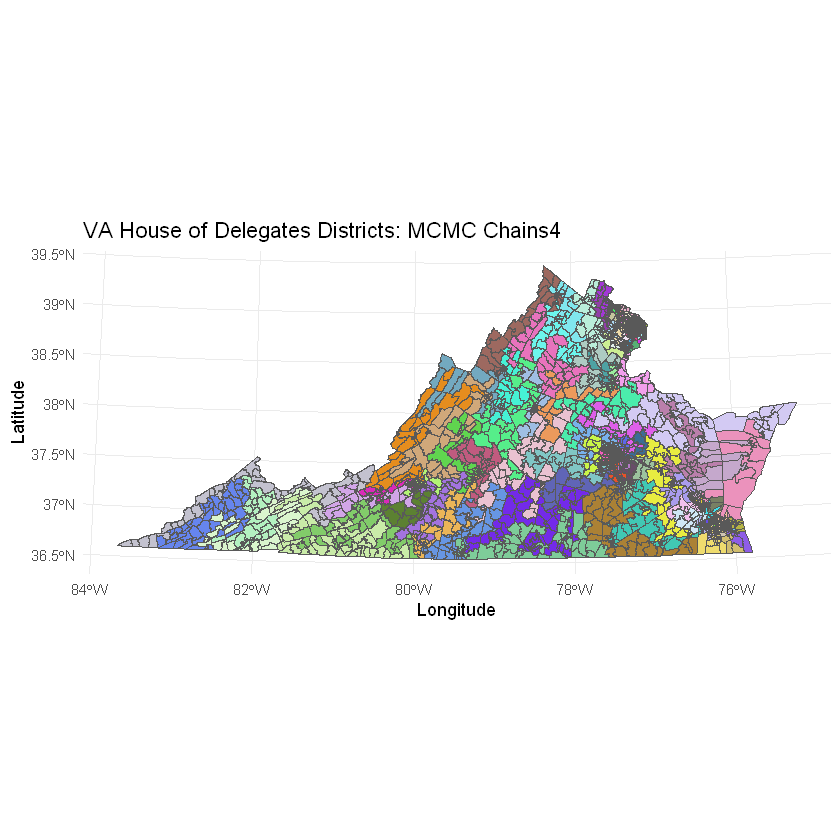

In [69]:
for (x in 1:4) {
    cds <- mcmc_chains[[x]]$partitions[,1]
    plot2 <- redist.map(shp=precinct.data, 
            district_membership=cds, 
            centroids=FALSE, 
            edges=FALSE,
            title=paste("VA House of Delegates Districts: MCMC Chains",toString(x), sep="")) +
            theme(legend.position="none") +
            scale_fill_manual(values = colors)
    ggsave(paste("mcmc_chains", toString(x),".png", sep=""), scale=2)
}

plot2

Saving 13.3 x 13.3 in image



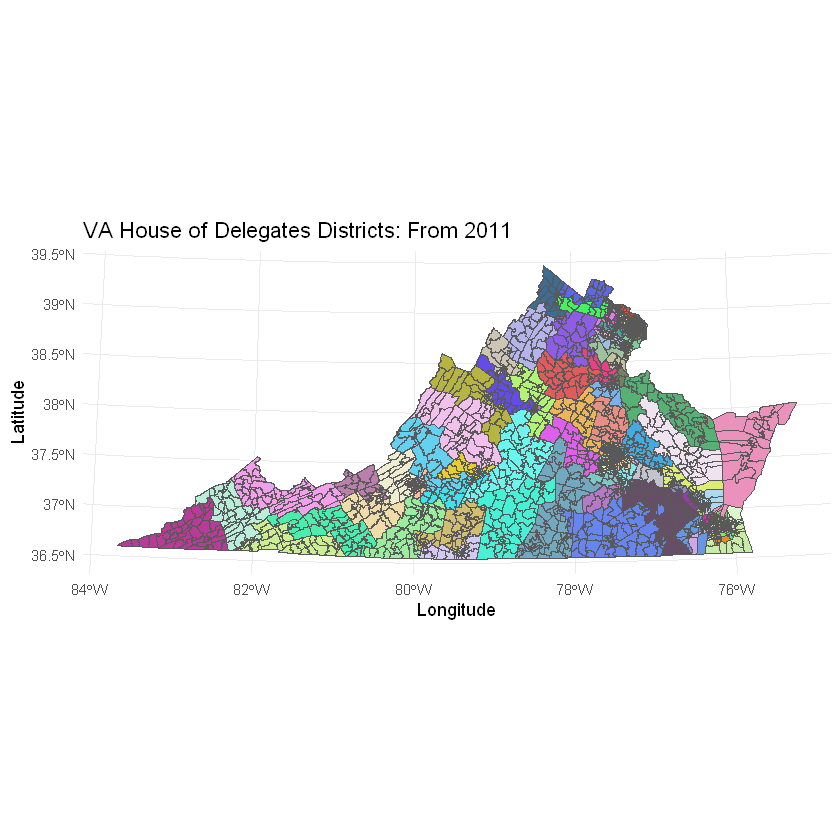

In [61]:
# These are the actual House of Delegates districts from 2011
cds <- mcmc_chains[[1]]$partitions[,1]
plot3 <- redist.map(shp=precinct.data, 
        district_membership=hid[,1], 
        centroids=FALSE, 
        edges=FALSE,
        #drop=TRUE,
        title="VA House of Delegates Districts: From 2011") +
        theme(legend.position="none") + 
        scale_fill_manual(values = colors)
        # geom_sf_label(aes(label = cds))
ggsave("hdist_11.png", scale=2)

plot3

### MCMC Using MPI

Supposedly, this is going to run much faster. I hope so. 

In [74]:
library(Rmpi)
#va.mcmc.mpi <- redist.mcmc.mpi(adjobj = adjlist,
#               popvec = precinct.data$pop,
#                nsims = 10000, 
#                ndists = 3,
#                savename = "redist.mcmc.mpi")

Ok, I'm giving up on MPI for now. I need to learn a lot more about running it on windows first. 

In [8]:
head(df)

,precinct,locality,loc_prec,district,G18DHOR,G18DSEN,G18OHOR,G18OSEN,G18RHOR,G18RSEN,...,ASIANVAP,NHPIVAP,OTHERVAP,X2MOREVAP,CD_12,CD_16,HDIST_11,HDIST_REM,SENDIST,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<MULTIPOLYGON [m]>
1,Glenkirk,Prince William County,Prince William County Glenkirk,Congressional District 1,980.0,1044.0,0.0,32.0,950.0,856.0,...,401,1.000000e+00,4,41,1,1,13,13,13,MULTIPOLYGON (((163199.1 30...
2,Buckland Mills,Prince William County,Prince William County Buckland Mills,Congressional District 1,938.0,978.0,0.0,31.0,766.0,701.0,...,449,1.190457e-07,6,73,1,1,13,13,13,MULTIPOLYGON (((162078.8 30...
3,Limestone,Prince William County,Prince William County Limestone,Congressional District 1,1471.0,1562.0,0.0,55.0,1232.0,1079.0,...,369,1.828088e-08,9,59,1,1,13,13,13,MULTIPOLYGON (((163554 3082...
4,Mullen,Prince William County,Prince William County Mullen,Congressional District 1,1312.0,1333.0,0.0,40.0,344.0,293.0,...,343,1.000000e+00,15,124,1,1,13,13,13,MULTIPOLYGON (((171765.7 31...
5,Sudley,Prince William County,Prince William County Sudley,Congressional District 1,727.0,737.0,0.0,44.0,520.0,467.0,...,134,2.000000e+00,8,49,1,1,13,13,29,MULTIPOLYGON (((174200.2 31...
6,Ben Lomond,Prince William County,Prince William County Ben Lomond,Congressional District 1,1131.0,1156.0,0.0,45.0,449.0,386.0,...,479,2.000000e+00,7,114,1,1,13,13,29,MULTIPOLYGON (((171651 3097...


In [15]:
df <- df[order(df$precinct),] %>%
    subset(select = -geometry) 
df%>% write.csv("va_precincts.csv")